## Section 1: Configuration & Imports

Set adjustable thresholds and import required libraries.

In [2]:
# ============================================================================
# CONFIGURATION - ADJUST THESE PARAMETERS AS NEEDED
# ============================================================================

# Trip Validity Thresholds
MIN_DRIVING_TIME_SEC = 60      # Minimum trip duration (seconds)
MIN_DISTANCE_KM = 0.5           # Minimum trip distance (km)

# Suspicious Distance Thresholds
SUSPICIOUS_DISTANCE_KM = 200    # High recorded distance threshold
SUSPICIOUS_HAVERSINE_KM = 20    # Low GPS distance threshold

# Substantial Trip Thresholds (for zero-events detection)
SUBSTANTIAL_DISTANCE_KM = 400   # Distance threshold for substantial trip
SUBSTANTIAL_TIME_SEC = 3600     # Time threshold (1 hour)

# Output Settings
OUTPUT_DIR = 'outputs'
OUTPUT_FILENAME = 'anomaly_trips.xlsx'

print('Configuration loaded:')
print(f'  - Valid trip: driving_time > {MIN_DRIVING_TIME_SEC}s AND distance > {MIN_DISTANCE_KM} km')
print(f'  - Suspicious distance: distance > {SUSPICIOUS_DISTANCE_KM} km AND haversine < {SUSPICIOUS_HAVERSINE_KM} km')
print(f'  - Substantial trip: distance > {SUBSTANTIAL_DISTANCE_KM} km OR time > {SUBSTANTIAL_TIME_SEC}s')
print(f'  - Output: {OUTPUT_DIR}/{OUTPUT_FILENAME}')

Configuration loaded:
  - Valid trip: driving_time > 60s AND distance > 0.5 km
  - Suspicious distance: distance > 200 km AND haversine < 20 km
  - Substantial trip: distance > 400 km OR time > 3600s
  - Output: outputs/anomaly_trips.xlsx


In [3]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime

# Optional: For BigQuery (uncomment if needed)
# import pydata_google_auth
# import pandas_gbq

print('Libraries imported successfully!')
print(f'  - pandas: {pd.__version__}')
print(f'  - numpy: {np.__version__}')

Libraries imported successfully!
  - pandas: 2.2.2
  - numpy: 1.26.4


## Section 2: Data Loading

Load trip data from CSV (recommended) or BigQuery.

In [4]:
# OPTION 1: Load from CSV (RECOMMENDED - Faster, no authentication needed)
csv_path = Path('trip_data.csv')

if csv_path.exists():
    df = pd.read_csv(csv_path)
    print(f'✓ Data loaded from CSV: {df.shape}')
    print(f'  - Rows: {len(df):,}')
    print(f'  - Columns: {len(df.columns)}')
else:
    raise FileNotFoundError(f'{csv_path} not found. Please ensure the data file exists or use BigQuery extraction below.')

✓ Data loaded from CSV: (103411, 36)
  - Rows: 103,411
  - Columns: 36


In [ ]:
# OPTION 2: BigQuery Extraction (OPTIONAL - Uncomment to use)
# Keep this code for reference, but CSV loading is preferred for performance

"""
# Uncomment this section to extract data from BigQuery:

SCOPES = ["https://www.googleapis.com/auth/bigquery"]

credentials = pydata_google_auth.get_user_credentials(
    SCOPES,
    auth_local_webserver=True,
)

query = '''
with del_user as (
  SELECT DISTINCT user_id
  FROM `datamart.bbr_fraud_monitor`
  WHERE flag_indicator = 'deleted user'
),

block_by_dmd as (
  SELECT DISTINCT user_id
  FROM `datamart.bbr_fraud_monitor`
  WHERE flag_indicator = 'blocked by DMD'
)

SELECT *
FROM `L1.bbr_fact_ps_trip_score` b1
LEFT JOIN del_user du ON b1.user_id = du.user_id
LEFT JOIN block_by_dmd db ON b1.user_id = db.user_id
'''

df = pandas_gbq.read_gbq(
    query,
    project_id="lgi-dt-dwh",
    credentials=credentials,
)

# Save to CSV for faster subsequent loads
df.to_csv('trip_data.csv', index=False)
print(f'✓ Data extracted from BigQuery and saved to trip_data.csv: {df.shape}')
"""

print('✓ BigQuery code available (commented out). Using CSV load by default.')

## Section 3: Feature Engineering

Calculate Haversine distance, distance difference, duration, and other derived features.

In [5]:
# Haversine formula to calculate straight-line GPS distance
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate great-circle distance between two points on Earth using Haversine formula.
    
    Parameters:
        lat1, lon1: Starting point coordinates (degrees)
        lat2, lon2: Ending point coordinates (degrees)
    
    Returns:
        Distance in kilometers
    """
    R = 6371  # Earth radius in km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c

# Calculate Haversine distance
df['distance_haversine'] = haversine(
    df['latitude_from'], 
    df['longitude_from'], 
    df['latitude_to'], 
    df['longitude_to']
)

print('✓ Haversine distance calculated!')
print(f'  - Mean haversine distance: {df["distance_haversine"].mean():.2f} km')
print(f'  - Max haversine distance: {df["distance_haversine"].max():.2f} km')

✓ Haversine distance calculated!
  - Mean haversine distance: 40.14 km
  - Max haversine distance: 10307.44 km


In [6]:
# Calculate engineered features
df['distance_diff'] = df['distance'] - df['distance_haversine']

# Convert dates to datetime and calculate duration
df['driving_date_from'] = pd.to_datetime(df['driving_date_from'])
df['driving_date_to'] = pd.to_datetime(df['driving_date_to'])
df['trip_duration_seconds'] = (df['driving_date_to'] - df['driving_date_from']).dt.total_seconds()
df['driving_duration_days'] = df['trip_duration_seconds'] / 86400

# Calculate sudden event metrics
sudden_cols = ['sudden_start_count', 'sudden_stop_count', 'sudden_acceleration_count', 'sudden_deceleration_count']
df['sudden_sum'] = df[sudden_cols].fillna(0).sum(axis=1)
df['sudden_per_hour'] = df['sudden_sum'] / (df['driving_time'] / 3600).replace(0, np.nan)

# Calculate distance rate
df['distance_per_hour'] = df['distance'] / (df['driving_time'] / 3600).replace(0, np.nan)

print('✓ Engineered features calculated:')
print('  - distance_diff (recorded - GPS)')
print('  - driving_duration_days')
print('  - sudden_sum, sudden_per_hour')
print('  - distance_per_hour')

✓ Engineered features calculated:
  - distance_diff (recorded - GPS)
  - driving_duration_days
  - sudden_sum, sudden_per_hour
  - distance_per_hour


## Section 4: Rule-Based Anomaly Flagging

Apply rule-based flags to identify suspicious trips.

In [7]:
# Trip Validity: Must have driving_time > threshold AND distance > threshold
valid_trip = (df['driving_time'] > MIN_DRIVING_TIME_SEC) & (df['distance'] > MIN_DISTANCE_KM)

# Categorize invalid trips
invalid_too_short_time = (df['driving_time'] <= MIN_DRIVING_TIME_SEC) & (df['distance'] > MIN_DISTANCE_KM)
invalid_too_short_dist = (df['driving_time'] > MIN_DRIVING_TIME_SEC) & (df['distance'] <= MIN_DISTANCE_KM)
invalid_both = (df['driving_time'] <= MIN_DRIVING_TIME_SEC) & (df['distance'] <= MIN_DISTANCE_KM)

# FLAG 1: Suspicious Distance (Odometer Fraud)
# High recorded distance but extremely low GPS distance
suspicious_distance = (df['distance'] > SUSPICIOUS_DISTANCE_KM) & (df['distance_haversine'] < SUSPICIOUS_HAVERSINE_KM)

# FLAG 2 & 3: Zero Sudden Events Flags
# Only flag when trip is substantial in distance or time
zero_sudden = (
    (df[sudden_cols].fillna(0) == 0).all(axis=1) & 
    ((df['distance'] > SUBSTANTIAL_DISTANCE_KM) | (df['driving_time'] > SUBSTANTIAL_TIME_SEC))
)

# FLAG 2: Data Integrity Issue
# Zero sudden events + EOT completed but no trip_point awarded
eot_zero_point = (df.get('eot') == 'Y') & (df.get('trip_point') == 0)
zero_sudden_and_eot_zero = zero_sudden & eot_zero_point

# FLAG 3: Zero Sudden Events Only
# Zero sudden events but doesn't match integrity issue pattern
zero_sudden_only = zero_sudden & ~eot_zero_point

# Attach all flags to dataframe
df['flag_valid_trip'] = valid_trip
df['flag_invalid_short_time'] = invalid_too_short_time
df['flag_invalid_short_distance'] = invalid_too_short_dist
df['flag_invalid_both'] = invalid_both
df['flag_suspicious_distance'] = suspicious_distance
df['flag_data_integrity_issue'] = zero_sudden_and_eot_zero
df['flag_zero_sudden_only'] = zero_sudden_only

# FLAG 4: Combined suspicious flag (any of the three above)
df['flag_any_suspicious'] = (
    df['flag_suspicious_distance'] | 
    df['flag_data_integrity_issue'] | 
    df['flag_zero_sudden_only']
)

# Combined: Valid trips with suspicious behavior
df['flag_valid_with_suspicious'] = valid_trip & df['flag_any_suspicious']

print('✓ Rule-based flags applied!')

✓ Rule-based flags applied!


In [8]:
# Rule flags (keep as columns for later cluster inspection)
sudden_cols = ['sudden_start_count','sudden_stop_count','sudden_acceleration_count','sudden_deceleration_count']

# Trip validity: must have driving_time > 60 sec AND distance > 0.5 km
min_driving_time_sec = 60
min_distance_km = 0.5
valid_trip = (df['driving_time'] > min_driving_time_sec) & (df['distance'] > min_distance_km)

# Categorize all trips by validity
invalid_too_short_time = (df['driving_time'] <= min_driving_time_sec) & (df['distance'] > min_distance_km)
invalid_too_short_dist = (df['driving_time'] > min_driving_time_sec) & (df['distance'] <= min_distance_km)
invalid_both = (df['driving_time'] <= min_driving_time_sec) & (df['distance'] <= min_distance_km)

# Suspicious distance: high recorded distance but extremely low haversine
# More conservative: >200 km recorded but <20 km haversine suggests local movement with inflated odometer
suspicious_distance = (df['distance'] > 200) & (df['distance_haversine'] < 20)

# Refined zero-sudden rule: only flag when trip is substantial in distance or time
threshold_distance_km = 400
threshold_driving_time_sec = 3600  # 1 hour
zero_sudden = ((df[sudden_cols].fillna(0) == 0).all(axis=1)) & \
               ((df['distance'] > threshold_distance_km) | (df['driving_time'] > threshold_driving_time_sec))

# Data integrity: zero sudden events + EOT completed but no trip_point
# If driver drove safely (no sudden events) but EOT=Y and trip_point=0, it's inconsistent
eot_zero_point = (df.get('eot') == 'Y') & (df.get('trip_point') == 0)
zero_sudden_and_eot_zero = zero_sudden & eot_zero_point
zero_sudden_only = zero_sudden & ~eot_zero_point  # keep variable for reporting

# Attach flags
df['flag_valid_trip'] = valid_trip
df['flag_invalid_short_time'] = invalid_too_short_time
df['flag_invalid_short_distance'] = invalid_too_short_dist
df['flag_invalid_both'] = invalid_both
df['flag_suspicious_distance'] = suspicious_distance
df['flag_data_integrity_issue'] = zero_sudden_and_eot_zero  # Merged flag: zero events + EOT but no points
df['flag_zero_sudden_only'] = zero_sudden_only  # Zero events but EOT incomplete or trip_point exists

# Combine suspicious behavior flags for valid trips
df['flag_any_suspicious'] = df['flag_suspicious_distance'] | df['flag_data_integrity_issue'] | df['flag_zero_sudden_only']
df['flag_valid_with_suspicious'] = valid_trip & df['flag_any_suspicious']

print('='*70)
print('TRIP CLASSIFICATION FLOW')
print('='*70)
print(f'\n1. TOTAL TRIPS: {len(df)}')
print(f'\n2. VALIDITY BREAKDOWN:')
print(f'   Valid trips: {valid_trip.sum()} ({100*valid_trip.sum()/len(df):.2f}%)')
print(f'      Meaning: Driving time > 60 sec AND distance > 0.5 km')
print(f'   Invalid trips: {(invalid_too_short_time | invalid_too_short_dist | invalid_both).sum()} ({100*(invalid_too_short_time | invalid_too_short_dist | invalid_both).sum()/len(df):.2f}%)')
print(f'     - Short time only: {invalid_too_short_time.sum()}  | driving_time <= 60s AND distance > 0.5 km')
print(f'     - Short distance only: {invalid_too_short_dist.sum()}  | driving_time > 60s AND distance <= 0.5 km')
print(f'     - Both too short: {invalid_both.sum()}  | driving_time <= 60s AND distance <= 0.5 km')

print(f'\n3. SUSPICIOUS BEHAVIOR (VALID TRIPS ONLY):')
print(f'   Valid trips with ANY suspicious flag: {df["flag_valid_with_suspicious"].sum()}')
print()
print(f'   a) Suspicious Distance (>200km & <20km haversine): {(valid_trip & suspicious_distance).sum()}')
print(f'      Users: {df.loc[valid_trip & suspicious_distance, "user_id"].nunique()}')
print(f'      Description: High recorded odometer distance but stayed within small local radius.')
print(f'      Implication: Possible odometer fraud, GPS spoofing, or system error.')
print()
print(f'   b) Data Integrity Issue (Zero events + EOT=Y but trip_point=0): {(valid_trip & zero_sudden_and_eot_zero).sum()}')
print(f'      Users: {df.loc[valid_trip & zero_sudden_and_eot_zero, "user_id"].nunique()}')
print(f'      Description: Safe driving (no sudden events) + trip completed (EOT=Y) but NO reward points.')
print(f'      Implication: Inconsistent data; if driver drove safely, should receive points. Indicates')
print(f'                   data corruption, system error, or incomplete trip recording.')
print()
print(f'   c) Zero Sudden Events Only (distance>400km OR time>1hr, incomplete EOT): {(valid_trip & zero_sudden_only).sum()}')
print(f'      Users: {df.loc[valid_trip & zero_sudden_only, "user_id"].nunique()}')
print(f'      Description: Substantial trip with no sudden events but trip not properly ended or has points.')
print(f'      Implication: Unrealistic driving behavior or incomplete session handling.')

print(f'\n4. USERS WITH SUSPICIOUS VALID TRIPS:')
suspicious_valid_df = df[df['flag_valid_with_suspicious']]
print(f'   Total unique users with suspicious trips: {suspicious_valid_df["user_id"].nunique()}')
print(f'   Total suspicious valid trips: {len(suspicious_valid_df)}')
print(f'\n   Top 10 users by suspicious trip count:')
suspicious_by_user = suspicious_valid_df['user_id'].value_counts().head(10)
print(suspicious_by_user)

TRIP CLASSIFICATION FLOW

1. TOTAL TRIPS: 103411

2. VALIDITY BREAKDOWN:
   Valid trips: 65156 (63.01%)
      Meaning: Driving time > 60 sec AND distance > 0.5 km
   Invalid trips: 38255 (36.99%)
     - Short time only: 7700  | driving_time <= 60s AND distance > 0.5 km
     - Short distance only: 16532  | driving_time > 60s AND distance <= 0.5 km
     - Both too short: 14023  | driving_time <= 60s AND distance <= 0.5 km

3. SUSPICIOUS BEHAVIOR (VALID TRIPS ONLY):
   Valid trips with ANY suspicious flag: 17014

   a) Suspicious Distance (>200km & <20km haversine): 30
      Users: 25
      Description: High recorded odometer distance but stayed within small local radius.
      Implication: Possible odometer fraud, GPS spoofing, or system error.

   b) Data Integrity Issue (Zero events + EOT=Y but trip_point=0): 6298
      Users: 232
      Description: Safe driving (no sudden events) + trip completed (EOT=Y) but NO reward points.
      Implication: Inconsistent data; if driver drove safel

In [16]:
# Filter by created_date_time and repeat classification summary (same logic as above)
# Set the date window you want to analyze
start_date = '2025-11-01'
end_date = '2025-12-07'

created_dt = pd.to_datetime(df['created_date_time'], errors='coerce')
date_mask = created_dt.between(pd.to_datetime(start_date), pd.to_datetime(end_date))
df_date = df.loc[date_mask].copy()

print('='*70)
print('TRIP CLASSIFICATION FLOW (DATE FILTERED)')
print('='*70)
print(f'Date range: {start_date} to {end_date}')
print(f'Trips in range: {len(df_date)} of {len(df)} total')

sudden_cols = ['sudden_start_count','sudden_stop_count','sudden_acceleration_count','sudden_deceleration_count']

# Trip validity using configured thresholds
valid_trip = (df_date['driving_time'] > MIN_DRIVING_TIME_SEC) & (df_date['distance'] > MIN_DISTANCE_KM)
invalid_too_short_time = (df_date['driving_time'] <= MIN_DRIVING_TIME_SEC) & (df_date['distance'] > MIN_DISTANCE_KM)
invalid_too_short_dist = (df_date['driving_time'] > MIN_DRIVING_TIME_SEC) & (df_date['distance'] <= MIN_DISTANCE_KM)
invalid_both = (df_date['driving_time'] <= MIN_DRIVING_TIME_SEC) & (df_date['distance'] <= MIN_DISTANCE_KM)

# Suspicious distance: high recorded distance but extremely low haversine
suspicious_distance = (df_date['distance'] > SUSPICIOUS_DISTANCE_KM) & (df_date['distance_haversine'] < SUSPICIOUS_HAVERSINE_KM)

# Zero sudden events rule (only when trip is substantial in distance or time)
zero_sudden = (
    (df_date[sudden_cols].fillna(0) == 0).all(axis=1) &
    ((df_date['distance'] > SUBSTANTIAL_DISTANCE_KM) | (df_date['driving_time'] > SUBSTANTIAL_TIME_SEC))
)

eot_zero_point = (df_date.get('eot') == 'Y') & (df_date.get('trip_point') == 0)
zero_sudden_and_eot_zero = zero_sudden & eot_zero_point
zero_sudden_only = zero_sudden & ~eot_zero_point

# ============================================================================
# ADDITIONAL ANOMALY DETECTIONS (A-E)
# ============================================================================

# (A) Distance Ratio Anomaly
DISTANCE_RATIO_THRESHOLD = 10  # Threshold for recorded/GPS distance ratio
df_date['distance_ratio'] = df_date['distance'] / df_date['distance_haversine'].replace(0, np.nan)
distance_ratio_anomaly = df_date['distance_ratio'] > DISTANCE_RATIO_THRESHOLD

# (B) Duration Feasibility Anomaly
MAX_REASONABLE_TRIP_SEC = 24 * 3600  # 24 hours
duration_anomaly = df_date['driving_time'] > MAX_REASONABLE_TRIP_SEC

# (C) Speed Feasibility
MIN_AVG_SPEED_KMH = 1
MAX_AVG_SPEED_KMH = 150
df_date['avg_speed'] = df_date['distance'] / (df_date['driving_time'] / 3600).replace(0, np.nan)
too_slow = df_date['avg_speed'] < MIN_AVG_SPEED_KMH
too_fast = df_date['avg_speed'] > MAX_AVG_SPEED_KMH
speed_anomaly = too_slow | too_fast

# (D) Event Density Consistency
MAX_EVENTS_THRESHOLD = 50  # Adjust based on your data
df_date['total_sudden_events'] = df_date[sudden_cols].fillna(0).sum(axis=1)
event_density_low = (df_date['total_sudden_events'] == 0) & (df_date['distance'] > SUBSTANTIAL_DISTANCE_KM)
event_density_high = df_date['total_sudden_events'] > MAX_EVENTS_THRESHOLD
event_density_anomaly = event_density_low | event_density_high

# (E) EOT Missing but Trip Looks Finished
missing_eot_but_stopped = (df_date.get('eot') == 'N') & (df_date['avg_speed'] < MIN_AVG_SPEED_KMH)

# Attach flags on the filtered frame (does not modify the main df)
df_date = df_date.assign(
    flag_valid_trip=valid_trip,
    flag_invalid_short_time=invalid_too_short_time,
    flag_invalid_short_distance=invalid_too_short_dist,
    flag_invalid_both=invalid_both,
    flag_suspicious_distance=suspicious_distance,
    flag_data_integrity_issue=zero_sudden_and_eot_zero,
    flag_zero_sudden_only=zero_sudden_only,
    # New flags
    flag_distance_ratio_anomaly=distance_ratio_anomaly,
    flag_duration_anomaly=duration_anomaly,
    flag_speed_anomaly=speed_anomaly,
    flag_event_density_anomaly=event_density_anomaly,
    flag_missing_eot_but_stopped=missing_eot_but_stopped
)

df_date['flag_any_suspicious'] = (
    df_date['flag_suspicious_distance'] |
    df_date['flag_data_integrity_issue'] |
    df_date['flag_zero_sudden_only'] |
    df_date['flag_distance_ratio_anomaly'] |
    df_date['flag_duration_anomaly'] |
    df_date['flag_speed_anomaly'] |
    df_date['flag_event_density_anomaly'] |
    df_date['flag_missing_eot_but_stopped']
)
df_date['flag_valid_with_suspicious'] = df_date['flag_valid_trip'] & df_date['flag_any_suspicious']

print(f'\n1. TOTAL TRIPS (filtered): {len(df_date)}')
print(f'\n2. VALIDITY BREAKDOWN:')
print(f'   Valid trips: {valid_trip.sum()} ({100*valid_trip.sum()/len(df_date):.2f}%)')
print(f'   Invalid trips: {(invalid_too_short_time | invalid_too_short_dist | invalid_both).sum()} ({100*(invalid_too_short_time | invalid_too_short_dist | invalid_both).sum()/len(df_date):.2f}%)')
print(f'     - Short time only: {invalid_too_short_time.sum()}')
print(f'     - Short distance only: {invalid_too_short_dist.sum()}')
print(f'     - Both too short: {invalid_both.sum()}')

print(f'\n3. SUSPICIOUS BEHAVIOR (VALID TRIPS ONLY):')
print(f'   Valid trips with ANY suspicious flag: {df_date["flag_valid_with_suspicious"].sum()}')
print()
print(f'   a) Suspicious Distance (> {SUSPICIOUS_DISTANCE_KM}km & < {SUSPICIOUS_HAVERSINE_KM}km): {(valid_trip & suspicious_distance).sum()}')
print(f'      Users: {df_date.loc[valid_trip & suspicious_distance, "user_id"].nunique()}')
print(f'      Meaning: High recorded odometer distance but GPS shows stayed within small local radius.')
print(f'      Implication: Likely odometer fraud, GPS spoofing, or system error.')
print()
print(f'   b) Data Integrity Issue (Zero events + EOT=Y but trip_point=0): {(valid_trip & zero_sudden_and_eot_zero).sum()}')
print(f'      Users: {df_date.loc[valid_trip & zero_sudden_and_eot_zero, "user_id"].nunique()}')
print(f'      Meaning: Driver drove safely (no sudden events) and completed trip (EOT=Y) but earned ZERO points.')
print(f'      Implication: Data corruption or system logic inconsistency - safe driving should earn points.')
print()
print(f'   c) Zero Sudden Events Only (distance>{SUBSTANTIAL_DISTANCE_KM}km OR time>{SUBSTANTIAL_TIME_SEC}s): {(valid_trip & zero_sudden_only).sum()}')
print(f'      Users: {df_date.loc[valid_trip & zero_sudden_only, "user_id"].nunique()}')
print(f'      Meaning: Substantial trip with ZERO sudden events - unrealistically perfect driving or incomplete session.')
print(f'      Implication: Either impossible perfect behavior or trip data not properly recorded/closed.')
print()
print(f'   d) Distance Ratio Anomaly (ratio > {DISTANCE_RATIO_THRESHOLD}): {(valid_trip & distance_ratio_anomaly).sum()}')
print(f'      Users: {df_date.loc[valid_trip & distance_ratio_anomaly, "user_id"].nunique()}')
print(f'      Meaning: Recorded distance is >10x the straight-line GPS distance.')
print(f'      Implication: Highly suspicious routing, GPS malfunction, or intentional odometer manipulation.')
print()
print(f'   e) Duration Anomaly (> {MAX_REASONABLE_TRIP_SEC/3600:.0f}h): {(valid_trip & duration_anomaly).sum()}')
print(f'      Users: {df_date.loc[valid_trip & duration_anomaly, "user_id"].nunique()}')
print(f'      Meaning: Trip lasted longer than {MAX_REASONABLE_TRIP_SEC/3600:.0f} continuous hours.')
print(f'      Implication: Unrealistic for human driver; likely system error, incomplete end-of-trip, or data corruption.')
print()
print(f'   f) Speed Anomaly (< {MIN_AVG_SPEED_KMH} or > {MAX_AVG_SPEED_KMH} km/h): {(valid_trip & speed_anomaly).sum()}')
print(f'      Users: {df_date.loc[valid_trip & speed_anomaly, "user_id"].nunique()}')
print(f'      Meaning: Average speed impossibly low (<1 km/h) or dangerously high (>150 km/h).')
print(f'      Implication: Low speed = system error/idle time counted as driving; High speed = reckless driving or GPS error.')
print()
print(f'   g) Event Density Anomaly (zero events or > {MAX_EVENTS_THRESHOLD}): {(valid_trip & event_density_anomaly).sum()}')
print(f'      Users: {df_date.loc[valid_trip & event_density_anomaly, "user_id"].nunique()}')
print(f'      Meaning: Either zero sudden events on long trip OR excessive sudden events (>50).')
print(f'      Implication: Zero = unrealistic safety record; High = vehicle malfunction, rough driving, or sensor errors.')
print()
print(f'   h) Missing EOT but Trip Stopped: {(valid_trip & missing_eot_but_stopped).sum()}')
print(f'      Users: {df_date.loc[valid_trip & missing_eot_but_stopped, "user_id"].nunique()}')
print(f'      Meaning: Vehicle stopped moving (avg speed <1 km/h) but EOT was not marked as completed.')
print(f'      Implication: Trip not properly closed in system - incomplete session handling or system bug.')

print(f'\n4. USERS WITH SUSPICIOUS VALID TRIPS:')
suspicious_valid_df = df_date[df_date['flag_valid_with_suspicious']]
print(f'   Total unique users with suspicious trips: {suspicious_valid_df["user_id"].nunique()}')
print(f'   Total suspicious valid trips: {len(suspicious_valid_df)}')
print(f'\n   Top 10 users by suspicious trip count:')
suspicious_by_user = suspicious_valid_df['user_id'].value_counts().head(10)
print(suspicious_by_user)


TRIP CLASSIFICATION FLOW (DATE FILTERED)
Date range: 2025-11-01 to 2025-12-07
Trips in range: 19448 of 103411 total

1. TOTAL TRIPS (filtered): 19448

2. VALIDITY BREAKDOWN:
   Valid trips: 12856 (66.10%)
   Invalid trips: 6592 (33.90%)
     - Short time only: 27
     - Short distance only: 3422
     - Both too short: 3143

3. SUSPICIOUS BEHAVIOR (VALID TRIPS ONLY):
   Valid trips with ANY suspicious flag: 4102

   a) Suspicious Distance (> 200km & < 20km): 6
      Users: 5
      Meaning: High recorded odometer distance but GPS shows stayed within small local radius.
      Implication: Likely odometer fraud, GPS spoofing, or system error.

   b) Data Integrity Issue (Zero events + EOT=Y but trip_point=0): 1642
      Users: 113
      Meaning: Driver drove safely (no sudden events) and completed trip (EOT=Y) but earned ZERO points.
      Implication: Data corruption or system logic inconsistency - safe driving should earn points.

   c) Zero Sudden Events Only (distance>400km OR time>360

In [18]:
# Top users per suspicious behavior (date-filtered)
print('\nTOP USERS PER SUSPICIOUS BEHAVIOR (DATE FILTERED)')

behaviors = {
    'Suspicious Distance (>200km & <20km haversine)': {
        'flag': df_date['flag_suspicious_distance'],
        'meaning': 'High recorded distance but stayed in small local area'
    },
    'Data Integrity Issue (Zero events + EOT=Y but no points)': {
        'flag': df_date['flag_data_integrity_issue'],
        'meaning': 'Safe driving but earned zero points - data inconsistency'
    },
    'Zero Sudden Events Only (substantial trip)': {
        'flag': df_date['flag_zero_sudden_only'],
        'meaning': 'Unrealistically perfect or incomplete trip recording'
    },
    'Distance Ratio Anomaly (>10x ratio)': {
        'flag': df_date['flag_distance_ratio_anomaly'],
        'meaning': 'Recorded distance far exceeds GPS distance'
    },
    'Duration Anomaly (>24h continuous)': {
        'flag': df_date['flag_duration_anomaly'],
        'meaning': 'Unrealistic trip duration for human driver'
    },
    'Speed Anomaly (<1 or >150 km/h)': {
        'flag': df_date['flag_speed_anomaly'],
        'meaning': 'Impossibly low or dangerously high average speed'
    },
    'Event Density Anomaly (zero or >50 events)': {
        'flag': df_date['flag_event_density_anomaly'],
        'meaning': 'Unrealistic safety record or excessive sudden events'
    },
    'Missing EOT but Stopped': {
        'flag': df_date['flag_missing_eot_but_stopped'],
        'meaning': 'Trip ended (stopped) but not marked complete'
    }
}

for label, data in behaviors.items():
    mask = data['flag']
    meaning = data['meaning']
    flagged = df_date[mask]
    user_counts = flagged['user_id'].value_counts().head(5)
    print(f'\n{label}')
    print(f'  Total trips: {len(flagged)}')
    print(f'  Meaning: {meaning}')
    if user_counts.empty:
        print('  → No users flagged')
    else:
        print('  → Top 5 users:')
        for user_id, cnt in user_counts.items():
            print(f'     User {user_id}: {cnt} trips')



TOP USERS PER SUSPICIOUS BEHAVIOR (DATE FILTERED)

Suspicious Distance (>200km & <20km haversine)
  Total trips: 6
  Meaning: High recorded distance but stayed in small local area
  → Top 5 users:
     User 185534: 2 trips
     User 168219: 1 trips
     User 174681: 1 trips
     User 184079: 1 trips
     User 184196: 1 trips

Data Integrity Issue (Zero events + EOT=Y but no points)
  Total trips: 1726
  Meaning: Safe driving but earned zero points - data inconsistency
  → Top 5 users:
     User 178644: 76 trips
     User 178517: 71 trips
     User 184170: 65 trips
     User 32273: 64 trips
     User 183298: 64 trips

Zero Sudden Events Only (substantial trip)
  Total trips: 1723
  Meaning: Unrealistically perfect or incomplete trip recording
  → Top 5 users:
     User 183298: 35 trips
     User 183286: 29 trips
     User 1515: 27 trips
     User 179373: 27 trips
     User 178517: 27 trips

Distance Ratio Anomaly (>10x ratio)
  Total trips: 1671
  Meaning: Recorded distance far exceeds

## Section 5: Exploratory Data Analysis (EDA)

Analyze feature distributions, correlations, and flag patterns for valid trips.

In [9]:
# Focus on valid trips for EDA
df_valid = df[df['flag_valid_trip']].copy()

print('='*80)
print('EDA: VALID TRIPS ONLY')
print('='*80)
print(f'Total valid trips: {len(df_valid):,}')
print(f'Suspicious valid trips: {df_valid["flag_any_suspicious"].sum():,} ({100*df_valid["flag_any_suspicious"].sum()/len(df_valid):.2f}%)')

EDA: VALID TRIPS ONLY
Total valid trips: 65,156
Suspicious valid trips: 17,014 (26.11%)


In [10]:
# Feature statistics
key_features = [
    'distance', 'distance_haversine', 'distance_diff',
    'driving_time', 'driving_duration_days',
    'trip_point', 'trip_safety_score',
    'sudden_sum', 'sudden_per_hour'
]

# Filter to features that exist
key_features = [f for f in key_features if f in df_valid.columns]

print('FEATURE STATISTICS (Valid Trips):')
print('='*80)
print(df_valid[key_features].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))

FEATURE STATISTICS (Valid Trips):
           distance  distance_haversine  distance_diff   driving_time  \
count  65156.000000        65156.000000   65156.000000   65156.000000   
mean      34.102550           16.538576      17.563974    4163.491743   
std      210.241228          122.473181     142.801103    7141.909840   
min        0.500266            0.000111   -3223.418123      61.000000   
25%        4.067061            1.693608       1.350450    1016.000000   
50%       10.285877            4.515212       4.118942    2310.000000   
75%       24.801949           10.090249      12.242947    5083.000000   
90%       47.319953           18.630198      29.708343    9585.000000   
95%       68.011287           25.739684      47.102677   13450.250000   
99%      298.306470          167.869026     102.446578   25064.800000   
max    13489.877104         4925.345245   11218.746426  500371.000000   

       driving_duration_days    trip_point  trip_safety_score    sudden_sum  \
count     

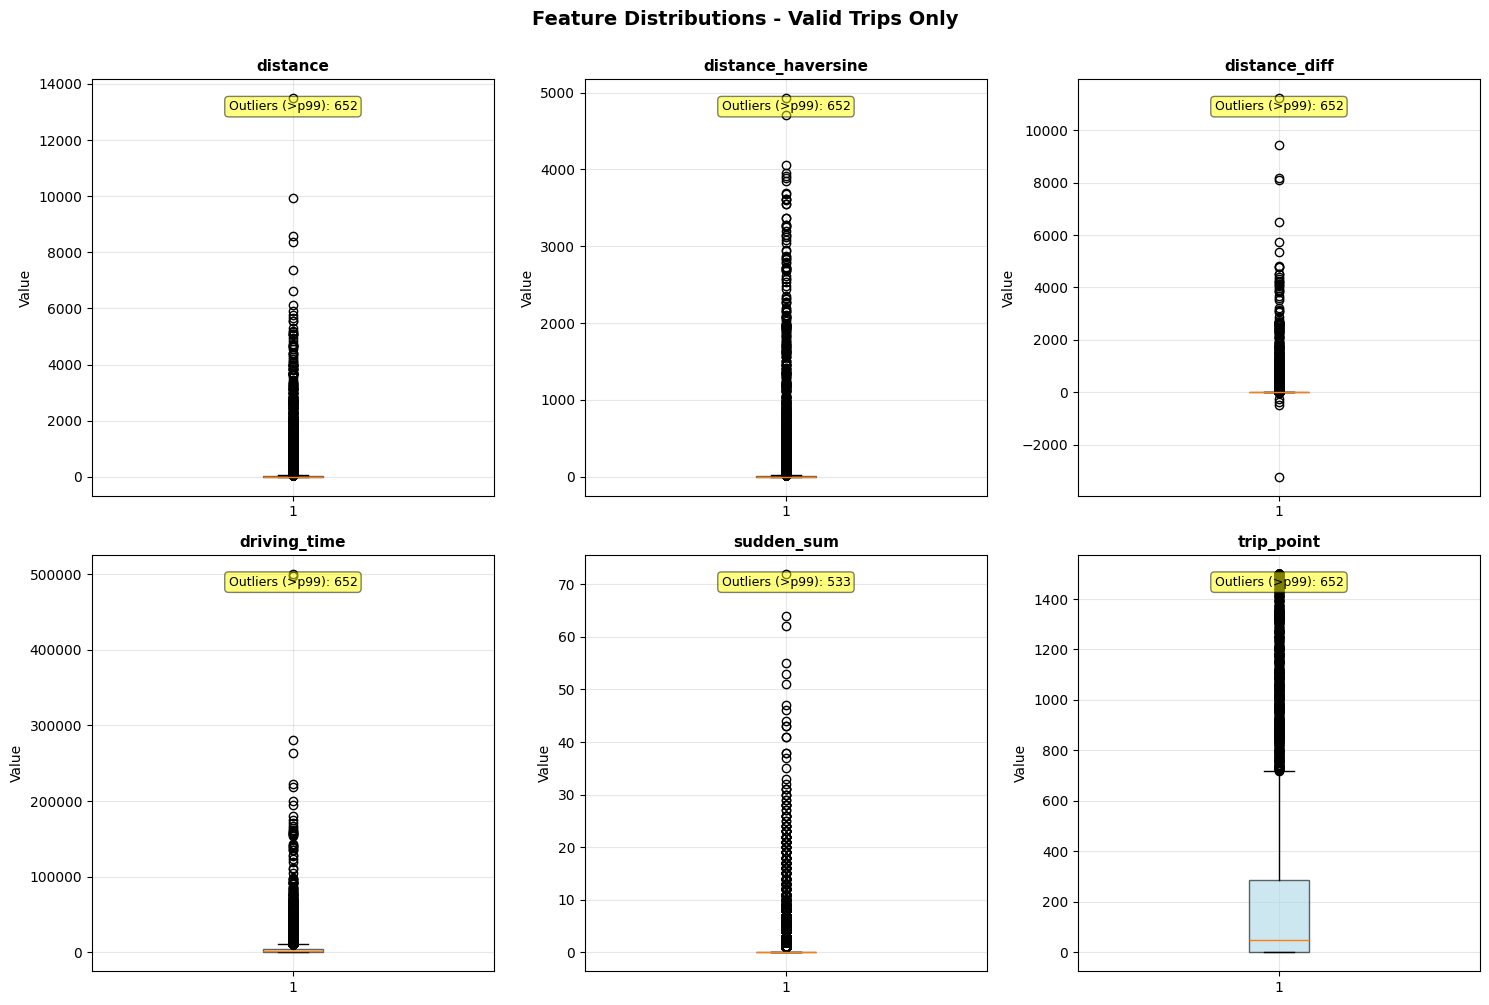

Boxplot interpretation:
  - Box = 25th-75th percentile (normal range)
  - Line = median
  - Outliers beyond whiskers = potential anomalies


In [11]:
# Boxplots for key features
plot_features = [
    'distance', 'distance_haversine', 'distance_diff',
    'driving_time', 'sudden_sum', 'trip_point'
]
plot_features = [f for f in plot_features if f in df_valid.columns]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(plot_features):
    ax = axes[i]
    ax.boxplot(df_valid[col].dropna(), vert=True, patch_artist=True,
               boxprops=dict(facecolor='lightblue', alpha=0.6))
    ax.set_title(f'{col}', fontsize=11, fontweight='bold')
    ax.set_ylabel('Value', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Show outlier count
    p99 = df_valid[col].quantile(0.99)
    outliers = (df_valid[col] > p99).sum()
    ax.text(0.5, 0.95, f'Outliers (>p99): {outliers}', 
            transform=ax.transAxes, ha='center', va='top', fontsize=9,
            bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

plt.suptitle('Feature Distributions - Valid Trips Only', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print('Boxplot interpretation:')
print('  - Box = 25th-75th percentile (normal range)')
print('  - Line = median')
print('  - Outliers beyond whiskers = potential anomalies')

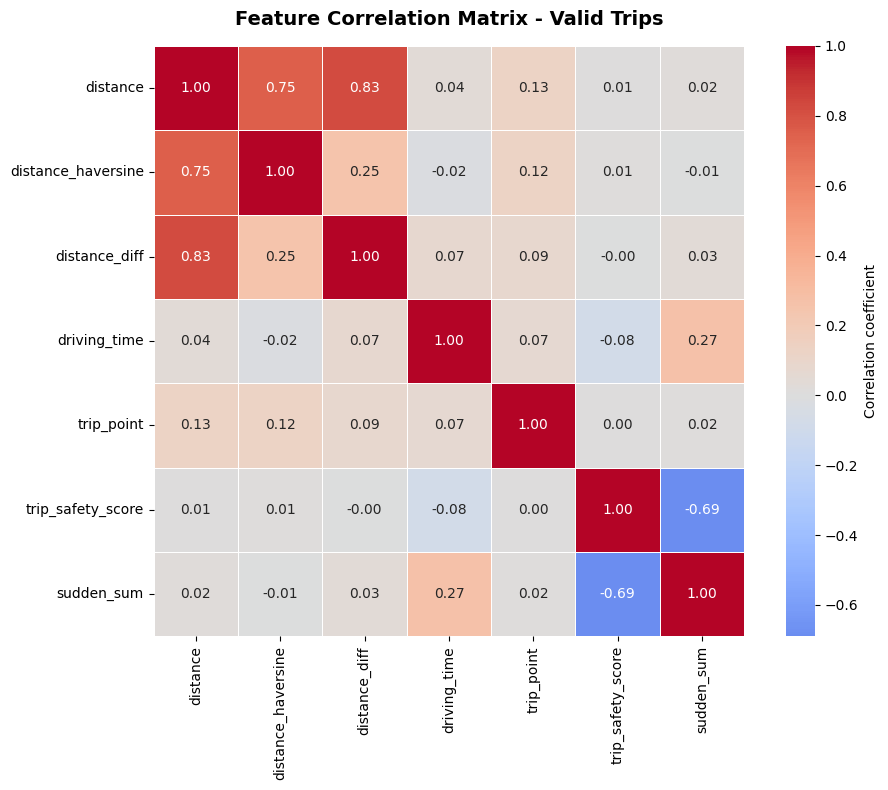

Correlation insights:
  - High correlation (>0.7): Features may be redundant
  - Low correlation (<0.3): Independent features
  - Use uncorrelated features for diverse anomaly detection


In [12]:
# Correlation heatmap
correlation_features = [
    'distance', 'distance_haversine', 'distance_diff',
    'driving_time', 'trip_point', 'trip_safety_score',
    'sudden_sum'
]
correlation_features = [f for f in correlation_features if f in df_valid.columns]

corr_matrix = df_valid[correlation_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=0.5,
            cbar_kws={'label': 'Correlation coefficient'})
plt.title('Feature Correlation Matrix - Valid Trips', fontsize=14, fontweight='bold', pad=15)
plt.tight_layout()
plt.show()

print('Correlation insights:')
print('  - High correlation (>0.7): Features may be redundant')
print('  - Low correlation (<0.3): Independent features')
print('  - Use uncorrelated features for diverse anomaly detection')

## Section 6: Analysis & Visualization

Visualize anomaly patterns and compare rule-based flags.

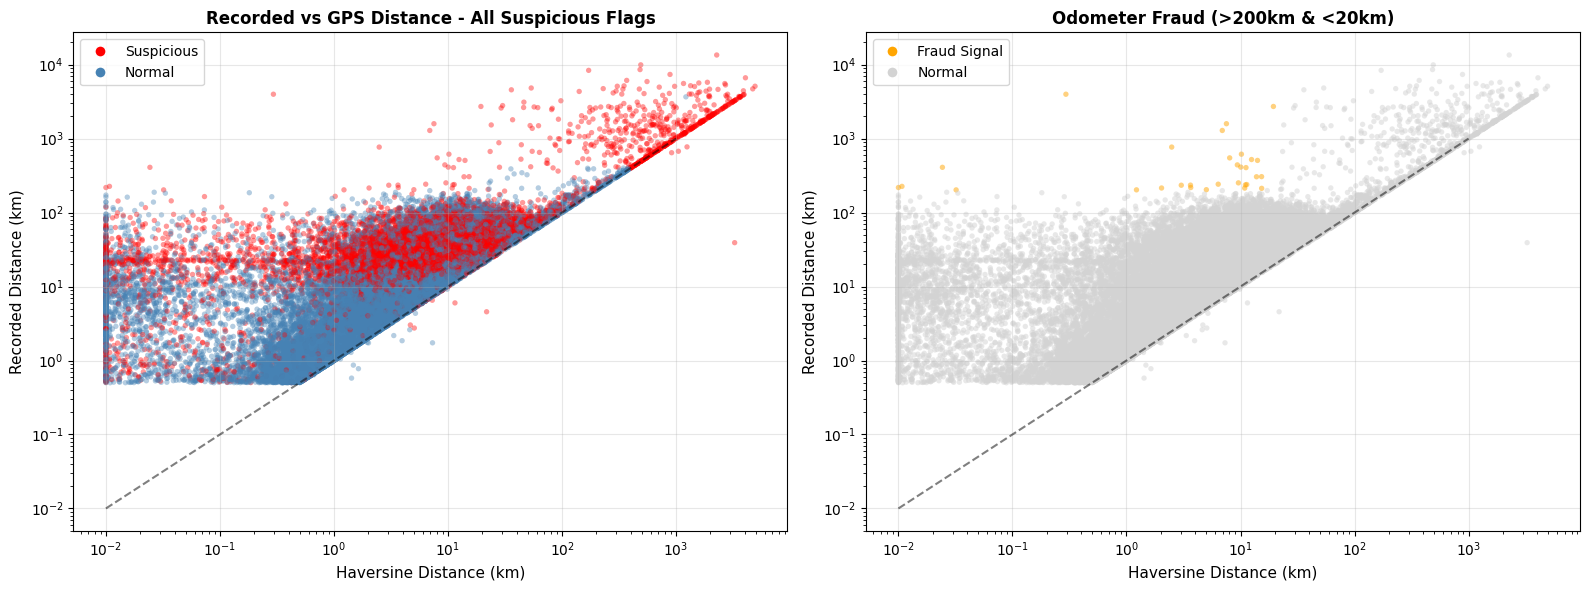

Visualization insights:
  - Points near y=x line: Recorded distance matches GPS (normal)
  - Points far above y=x line: High recorded, low GPS (potential fraud)
  - Orange points: Flagged as suspicious_distance


In [13]:
# Scatter plot: Distance vs Haversine (colored by suspicious flag)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: All trips colored by flag_any_suspicious
colors = df_valid['flag_any_suspicious'].map({True: 'red', False: 'steelblue'})
ax1.scatter(
    df_valid['distance_haversine'].clip(lower=0.01),
    df_valid['distance'].clip(lower=0.01),
    c=colors,
    alpha=0.4,
    s=15,
    edgecolors='none'
)
ax1.plot([0.01, 1000], [0.01, 1000], 'k--', lw=1.5, alpha=0.5, label='y=x (perfect match)')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('Haversine Distance (km)', fontsize=11)
ax1.set_ylabel('Recorded Distance (km)', fontsize=11)
ax1.set_title('Recorded vs GPS Distance - All Suspicious Flags', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Suspicious', markerfacecolor='red', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Normal', markerfacecolor='steelblue', markersize=8)
]
ax1.legend(handles=legend_elements, loc='upper left')

# Plot 2: Focus on suspicious_distance flag only
colors2 = df_valid['flag_suspicious_distance'].map({True: 'orange', False: 'lightgray'})
ax2.scatter(
    df_valid['distance_haversine'].clip(lower=0.01),
    df_valid['distance'].clip(lower=0.01),
    c=colors2,
    alpha=0.5,
    s=15,
    edgecolors='none'
)
ax2.plot([0.01, 1000], [0.01, 1000], 'k--', lw=1.5, alpha=0.5, label='y=x')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel('Haversine Distance (km)', fontsize=11)
ax2.set_ylabel('Recorded Distance (km)', fontsize=11)
ax2.set_title(f'Odometer Fraud (>{SUSPICIOUS_DISTANCE_KM}km & <{SUSPICIOUS_HAVERSINE_KM}km)', 
              fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
legend_elements2 = [
    Line2D([0], [0], marker='o', color='w', label='Fraud Signal', markerfacecolor='orange', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Normal', markerfacecolor='lightgray', markersize=8)
]
ax2.legend(handles=legend_elements2, loc='upper left')

plt.tight_layout()
plt.show()

print('Visualization insights:')
print('  - Points near y=x line: Recorded distance matches GPS (normal)')
print('  - Points far above y=x line: High recorded, low GPS (potential fraud)')
print('  - Orange points: Flagged as suspicious_distance')

In [14]:
# Flag distribution breakdown
flag_cols = ['flag_suspicious_distance', 'flag_data_integrity_issue', 'flag_zero_sudden_only', 'flag_any_suspicious']

print('='*80)
print('FLAG DISTRIBUTION ANALYSIS')
print('='*80)

for flag in flag_cols:
    if flag in df_valid.columns:
        count = df_valid[flag].sum()
        pct = 100 * count / len(df_valid)
        print(f'\n{flag}:')
        print(f'  Count: {count:,} trips ({pct:.2f}% of valid trips)')
        
        # Top 5 users for this flag
        if count > 0:
            top_users = df_valid[df_valid[flag]]['user_id'].value_counts().head(5)
            print(f'  Top 5 users:')
            for user_id, trip_count in top_users.items():
                print(f'    User {user_id}: {trip_count} trips')

FLAG DISTRIBUTION ANALYSIS

flag_suspicious_distance:
  Count: 30 trips (0.05% of valid trips)
  Top 5 users:
    User 161815: 3 trips
    User 11434: 2 trips
    User 185534: 2 trips
    User 178339: 2 trips
    User 32283: 1 trips

flag_data_integrity_issue:
  Count: 6,298 trips (9.67% of valid trips)
  Top 5 users:
    User 178517: 310 trips
    User 32273: 269 trips
    User 161890: 255 trips
    User 161337: 240 trips
    User 179373: 165 trips

flag_zero_sudden_only:
  Count: 10,694 trips (16.41% of valid trips)
  Top 5 users:
    User 1515: 170 trips
    User 178517: 137 trips
    User 178547: 136 trips
    User 179373: 134 trips
    User 11441: 123 trips

flag_any_suspicious:
  Count: 17,014 trips (26.11% of valid trips)
  Top 5 users:
    User 178517: 447 trips
    User 161337: 352 trips
    User 32273: 348 trips
    User 161890: 342 trips
    User 1515: 319 trips


## Section 7: Simplified User Profiling

Aggregate trips by user and identify high-risk users.

In [15]:
# User-level aggregation
print('='*80)
print('USER-LEVEL PROFILING')
print('='*80)

# Aggregate by user
user_summary = df_valid.groupby('user_id').agg(
    total_trips=('trip_id', 'count'),
    total_distance=('distance', 'sum'),
    mean_distance=('distance', 'mean'),
    total_driving_time=('driving_time', 'sum'),
    
    # Suspicious flags
    suspicious_distance_count=('flag_suspicious_distance', 'sum'),
    data_integrity_count=('flag_data_integrity_issue', 'sum'),
    zero_sudden_count=('flag_zero_sudden_only', 'sum'),
    total_suspicious_count=('flag_any_suspicious', 'sum'),
    
    # Scoring metrics
    mean_trip_point=('trip_point', 'mean'),
    mean_safety_score=('trip_safety_score', 'mean'),
    mean_distance_diff=('distance_diff', 'mean')
).reset_index()

# Calculate percentage of suspicious trips
user_summary['pct_suspicious'] = (
    100 * user_summary['total_suspicious_count'] / user_summary['total_trips']
)

# Identify high-risk users (>= 1 suspicious trip)
high_risk_users = user_summary[user_summary['total_suspicious_count'] > 0].copy()
high_risk_users = high_risk_users.sort_values('total_suspicious_count', ascending=False)

print(f'\nTotal users: {len(user_summary):,}')
print(f'High-risk users (>= 1 suspicious trip): {len(high_risk_users):,}')
print(f'Percentage of users with anomalies: {100*len(high_risk_users)/len(user_summary):.2f}%')

print(f'\nTop 20 High-Risk Users:')
print(high_risk_users[['user_id', 'total_trips', 'total_suspicious_count', 'pct_suspicious', 
                        'suspicious_distance_count', 'data_integrity_count', 'zero_sudden_count']].head(20))

USER-LEVEL PROFILING

Total users: 928
High-risk users (>= 1 suspicious trip): 725
Percentage of users with anomalies: 78.12%

Top 20 High-Risk Users:
     user_id  total_trips  total_suspicious_count  pct_suspicious  \
478   178517          947                     447       47.201690   
411   161337          973                     352       36.176773   
335    32273         1001                     348       34.765235   
423   161890          978                     342       34.969325   
59      1515          716                     319       44.553073   
546   179373          650                     299       46.000000   
480   178547          513                     235       45.808967   
488   178644          621                     221       35.587762   
396   160887          470                     210       44.680851   
390    62390          496                     202       40.725806   
678   183298          396                     190       47.979798   
188    11466         

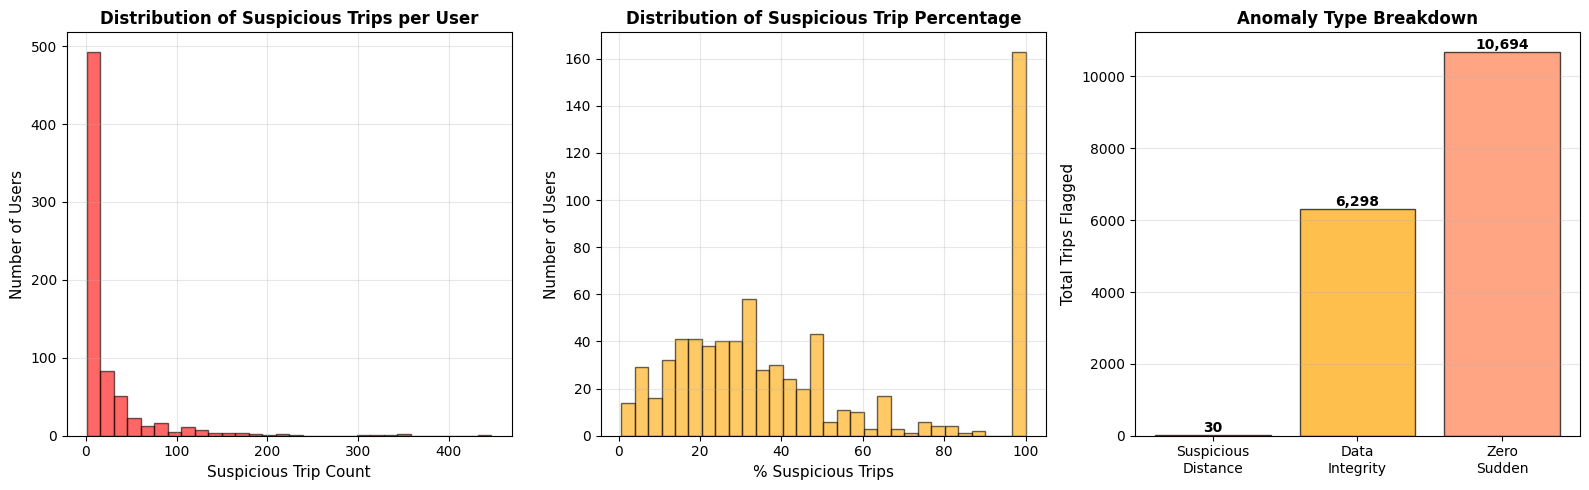

In [16]:
# User risk distribution
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Plot 1: Distribution of suspicious trip count per user
ax = axes[0]
ax.hist(high_risk_users['total_suspicious_count'], bins=30, color='red', alpha=0.6, edgecolor='black')
ax.set_xlabel('Suspicious Trip Count', fontsize=11)
ax.set_ylabel('Number of Users', fontsize=11)
ax.set_title('Distribution of Suspicious Trips per User', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

# Plot 2: Percentage of suspicious trips
ax = axes[1]
ax.hist(high_risk_users['pct_suspicious'], bins=30, color='orange', alpha=0.6, edgecolor='black')
ax.set_xlabel('% Suspicious Trips', fontsize=11)
ax.set_ylabel('Number of Users', fontsize=11)
ax.set_title('Distribution of Suspicious Trip Percentage', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

# Plot 3: Flag type breakdown
ax = axes[2]
flag_counts = {
    'Suspicious\nDistance': high_risk_users['suspicious_distance_count'].sum(),
    'Data\nIntegrity': high_risk_users['data_integrity_count'].sum(),
    'Zero\nSudden': high_risk_users['zero_sudden_count'].sum()
}
bars = ax.bar(flag_counts.keys(), flag_counts.values(), color=['red', 'orange', 'coral'], alpha=0.7, edgecolor='black')
ax.set_ylabel('Total Trips Flagged', fontsize=11)
ax.set_title('Anomaly Type Breakdown', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

## Section 8: Export Results

Export flagged trips and user IDs to Excel with 2 sheets.

In [17]:
# Create output directory if it doesn't exist
output_path = Path(OUTPUT_DIR)
output_path.mkdir(exist_ok=True)

# Prepare data for export
# Sheet 1: All flagged trips with all columns
flagged_trips = df_valid[df_valid['flag_any_suspicious']].copy()

# Sheet 2: User IDs only (high-risk users)
user_ids_only = high_risk_users[['user_id', 'total_trips', 'total_suspicious_count', 'pct_suspicious']].copy()
user_ids_only.columns = ['user_id', 'total_trips', 'suspicious_trips', 'pct_suspicious']

print('='*80)
print('EXPORT SUMMARY')
print('='*80)
print(f'\nSheet 1 - All Flagged Trips:')
print(f'  Rows: {len(flagged_trips):,}')
print(f'  Columns: {len(flagged_trips.columns)}')
print(f'  Includes all original columns plus flag columns')

print(f'\nSheet 2 - User IDs Only:')
print(f'  Rows: {len(user_ids_only):,} (unique users with anomalies)')
print(f'  Columns: {len(user_ids_only.columns)} (user_id, total_trips, suspicious_trips, pct_suspicious)')

# Export to Excel
output_file = output_path / OUTPUT_FILENAME

try:
    with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
        flagged_trips.to_excel(writer, sheet_name='Flagged_Trips', index=False)
        user_ids_only.to_excel(writer, sheet_name='User_IDs', index=False)
    
    print(f'\n✓ Export successful!')
    print(f'  File saved to: {output_file.absolute()}')
    print(f'  File size: {output_file.stat().st_size / 1024:.2f} KB')
    
except Exception as e:
    print(f'\n✗ Export failed: {e}')
    print(f'  Tip: Make sure Excel is not currently open with this file')

EXPORT SUMMARY

Sheet 1 - All Flagged Trips:
  Rows: 17,014
  Columns: 52
  Includes all original columns plus flag columns

Sheet 2 - User IDs Only:
  Rows: 725 (unique users with anomalies)
  Columns: 4 (user_id, total_trips, suspicious_trips, pct_suspicious)

✓ Export successful!
  File saved to: d:\Enzi-Folder\Analisis Anomali\outputs\anomaly_trips.xlsx
  File size: 5296.56 KB

✓ Export successful!
  File saved to: d:\Enzi-Folder\Analisis Anomali\outputs\anomaly_trips.xlsx
  File size: 5296.56 KB


In [18]:
# Optional: Preview exported data
print('\n' + '='*80)
print('EXPORT PREVIEW')
print('='*80)

print(f'\nSheet 1 - Flagged Trips (first 5 rows):')
display_cols = ['user_id', 'trip_id', 'distance', 'distance_haversine', 'distance_diff', 
                'flag_suspicious_distance', 'flag_data_integrity_issue', 'flag_zero_sudden_only']
display_cols = [col for col in display_cols if col in flagged_trips.columns]
print(flagged_trips[display_cols].head())

print(f'\nSheet 2 - User IDs (first 10 rows):')
print(user_ids_only.head(10))


EXPORT PREVIEW

Sheet 1 - Flagged Trips (first 5 rows):
    user_id                               trip_id   distance  \
17    19307  074b1fce-d264-49eb-a835-d81d3f05ba00  20.268470   
21    19307  1b96c275-edce-45ad-8200-95ca7ae065f8  20.042368   
24    19307  24a64597-fc29-4628-b63a-73a374918df8  20.822168   
28    19307  37b6c719-86c0-41fa-a9b3-90dd1021ad53  19.257822   
34    19307  62857096-d69a-4a9e-b11d-8493f9f41eff  19.242959   

    distance_haversine  distance_diff  flag_suspicious_distance  \
17           13.503527       6.764943                     False   
21           13.606402       6.435966                     False   
24           13.512403       7.309765                     False   
28           13.632302       5.625520                     False   
34           13.661971       5.580989                     False   

    flag_data_integrity_issue  flag_zero_sudden_only  
17                      False                   True  
21                      False                

## Section 9: Analysis Summary

Final summary of anomaly detection results.

In [ ]:
# Final summary report
print('='*80)
print('ANOMALY DETECTION PIPELINE - FINAL SUMMARY')
print('='*80)

print(f'\n📊 DATA OVERVIEW:')
print(f'  Total trips in dataset: {len(df):,}')
print(f'  Valid trips (>{MIN_DRIVING_TIME_SEC}s & >{MIN_DISTANCE_KM}km): {len(df_valid):,} ({100*len(df_valid)/len(df):.1f}%)')
print(f'  Invalid trips: {len(df) - len(df_valid):,}')

print(f'\n⚠️  ANOMALY DETECTION RESULTS:')
print(f'  Trips flagged as suspicious: {flagged_trips.shape[0]:,} ({100*flagged_trips.shape[0]/len(df_valid):.2f}% of valid)')
print(f'  Users with >= 1 suspicious trip: {len(high_risk_users):,} ({100*len(high_risk_users)/len(user_summary):.2f}% of users)')

print(f'\n🔍 ANOMALY TYPE BREAKDOWN:')
print(f'  Suspicious Distance (>{SUSPICIOUS_DISTANCE_KM}km & <{SUSPICIOUS_HAVERSINE_KM}km): {df_valid["flag_suspicious_distance"].sum():,}')
print(f'  Data Integrity Issues: {df_valid["flag_data_integrity_issue"].sum():,}')
print(f'  Zero Sudden Events: {df_valid["flag_zero_sudden_only"].sum():,}')

print(f'\n📁 EXPORTED FILES:')
print(f'  Location: {output_file.absolute()}')
print(f'  Sheet 1 (Flagged_Trips): {len(flagged_trips):,} rows, {len(flagged_trips.columns)} columns')
print(f'  Sheet 2 (User_IDs): {len(user_ids_only):,} rows, {len(user_ids_only.columns)} columns')

print(f'\n🎯 TOP 5 HIGH-RISK USERS:')
for idx, row in high_risk_users.head(5).iterrows():
    print(f'  User {row["user_id"]}: {int(row["total_suspicious_count"])} suspicious trips ({row["pct_suspicious"]:.1f}% of {int(row["total_trips"])} total)')

print(f'\n✓ Analysis complete! Review exported Excel file for detailed results.')
print('='*80)

ANOMALY DETECTION PIPELINE - FINAL SUMMARY

📊 DATA OVERVIEW:
  Total trips in dataset: 103,411
  Valid trips (>60s & >0.5km): 65,156 (63.0%)
  Invalid trips: 38,255

⚠️  ANOMALY DETECTION RESULTS:
  Trips flagged as suspicious: 17,014 (26.11% of valid)
  Users with >= 1 suspicious trip: 725 (78.12% of users)

🔍 ANOMALY TYPE BREAKDOWN:
  Suspicious Distance (>200km & <20km): 30
  Data Integrity Issues: 6,298
  Zero Sudden Events: 10,694

📁 EXPORTED FILES:
  Location: d:\Enzi-Folder\Analisis Anomali\outputs\anomaly_trips.xlsx
  Sheet 1 (Flagged_Trips): 17,014 rows, 52 columns
  Sheet 2 (User_IDs): 725 rows, 4 columns

🎯 TOP 5 HIGH-RISK USERS:
  User 178517.0: 447 suspicious trips (47.2% of 947 total)
  User 161337.0: 352 suspicious trips (36.2% of 973 total)
  User 32273.0: 348 suspicious trips (34.8% of 1001 total)
  User 161890.0: 342 suspicious trips (35.0% of 978 total)
  User 1515.0: 319 suspicious trips (44.6% of 716 total)

✓ Analysis complete! Review exported Excel file for detai

: 